In [1]:
import sys
sys.path.append('..')
from Comms_System import Comms_System
import numpy as np
import matplotlib.pyplot as plt
import torch
from NetworkPytorch import joint_train_loop
from DE_Pytorch import DE
from scipy import signal
import scipy

In [2]:
# Create Data

def get_data(num_symbols=10000):

    symbol_set = [3, 1, -1, -3] # all symbols that we use
    symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
    m = 8
    CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)

    upsampled = CS.upsample()
    X_tx = torch.Tensor(upsampled).view(1, 1, -1)

    classes = np.array(symbol_set)
    y = symbol_seq
    class_idx = {v: i for i, v in enumerate(classes)}
    y_idx = np.array([class_idx[v] for v in y])
    y = torch.Tensor(y_idx)
    
    return X_tx, y, CS

In [3]:
# Create 1D Convolutional Neural Networks for transmitter and receiver and define optimizer and loss

Xtrain, ytrain, CS = get_data(num_symbols=10000)

NN_tx = torch.nn.Sequential(torch.nn.Conv1d(1, 1, 64, padding=len(CS.h)-1)) # padding=len(CS.h) - 1
NN_rx = torch.nn.Sequential(torch.nn.Conv1d(1, 1, 64), torch.nn.Conv1d(1, 4, 8, stride=8))
criterion = torch.nn.CrossEntropyLoss()
params = list(NN_tx.parameters()) + list(NN_rx.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3)

299  loss: 0.4968325197696686
299  acc: 0.7853000164031982


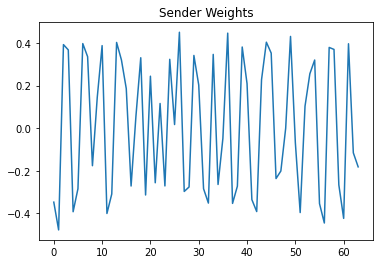

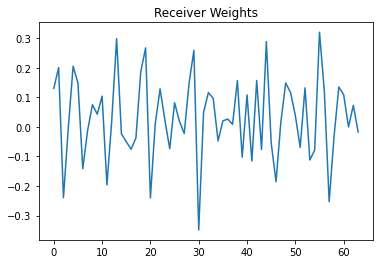

599  loss: 0.17248648405075073
599  acc: 0.9369999766349792


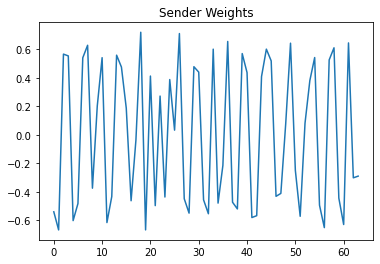

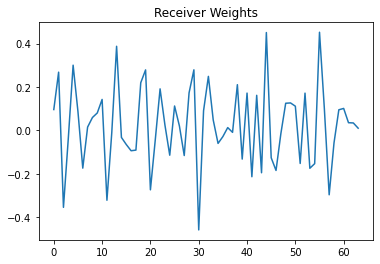

899  loss: 0.07546402513980865
899  acc: 0.9753999710083008


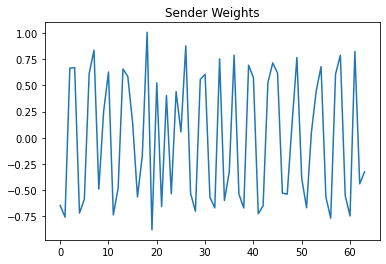

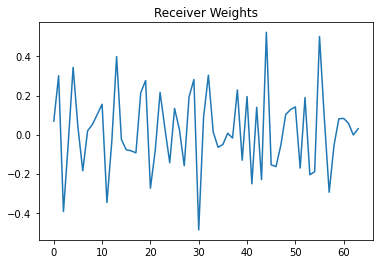

1199  loss: 0.036038320511579514
1199  acc: 0.989799976348877


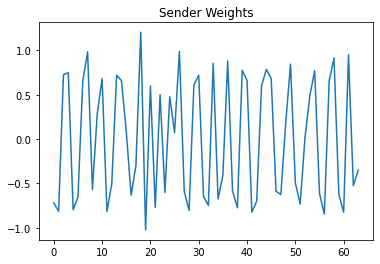

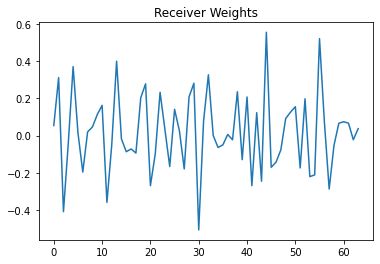

1499  loss: 0.024385225027799606
1499  acc: 0.9933000206947327


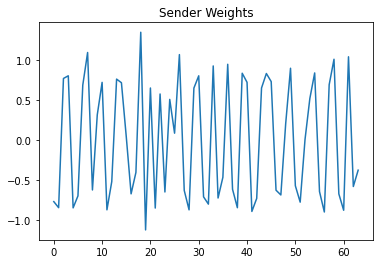

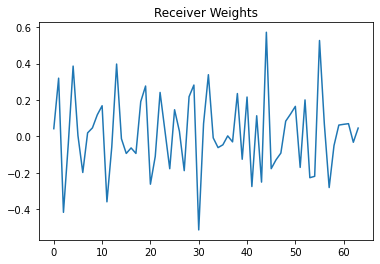

1799  loss: 0.013167966157197952
1799  acc: 0.9962999820709229


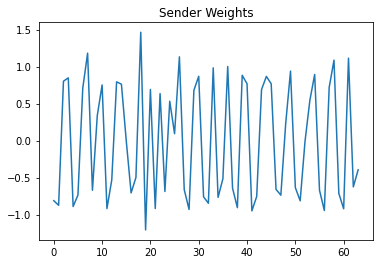

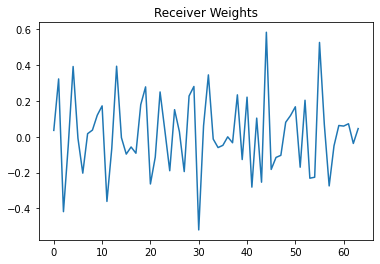

2099  loss: 0.009842431172728539
2099  acc: 0.9977999925613403


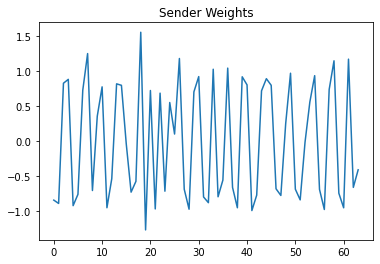

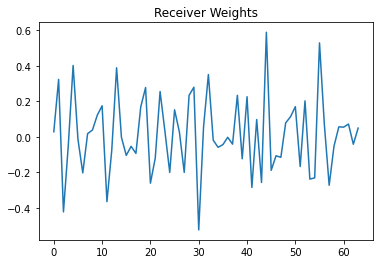

2399  loss: 0.006697875913232565
2399  acc: 0.998199999332428


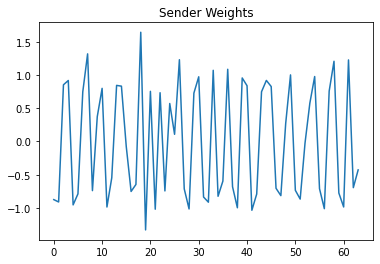

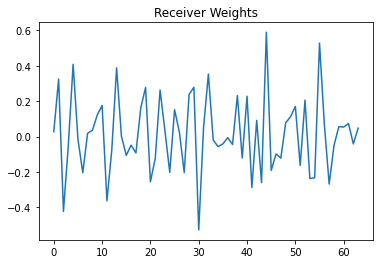

2699  loss: 0.004916499834507704
2699  acc: 0.9987000226974487


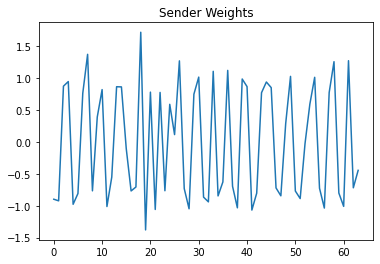

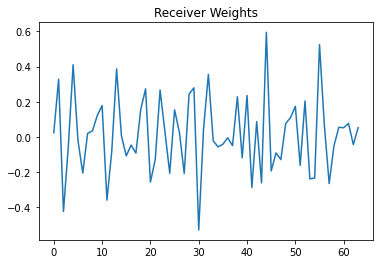

2999  loss: 0.005377928726375103
2999  acc: 0.9984999895095825


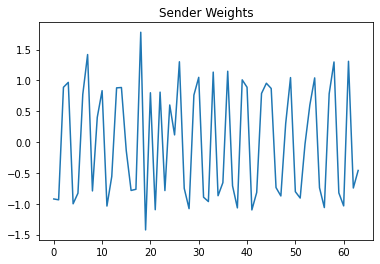

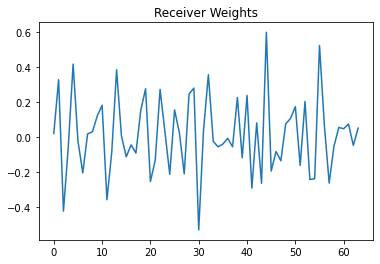

3299  loss: 0.002656779019162059
3299  acc: 0.9997000098228455


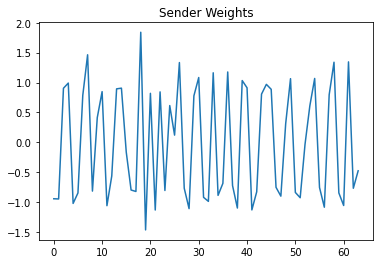

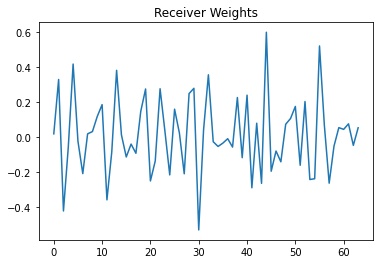

3599  loss: 0.002241062466055155
3599  acc: 0.9994999766349792


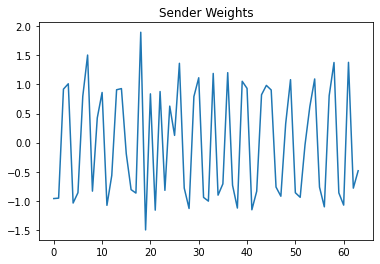

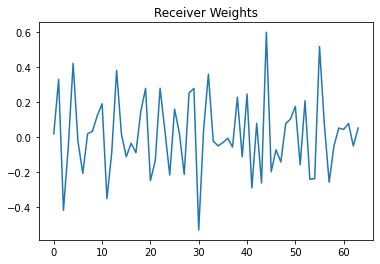

3899  loss: 0.0020406628027558327
3899  acc: 0.9994000196456909


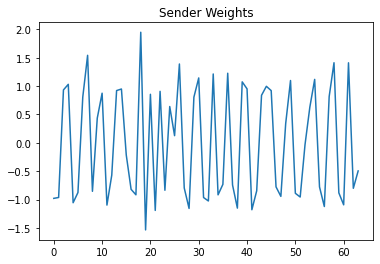

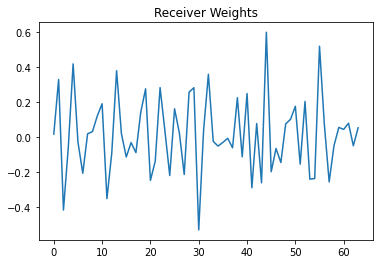

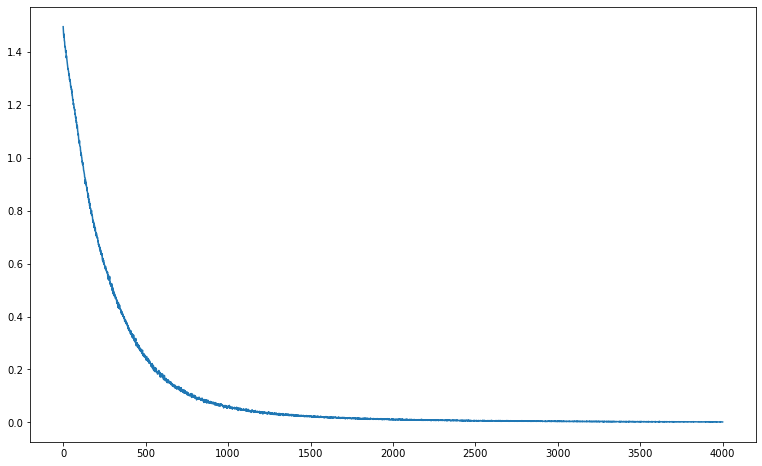

In [4]:
# Joint train sender and receiver NN using Backpropagation

epoch_losses = joint_train_loop(NN_tx, NN_rx, Xtrain, ytrain, optimizer, criterion, lowpass=False,
                                sample_rate=CS.m, epochs=4000, v=True)

plt.figure(figsize=(13, 8))
plt.plot(epoch_losses)
plt.show()

In [12]:
# Evaluate

def evaluate_yo(sigma, Xtest, ytest, CStest):

    #Xtest, ytest, CStest = get_data(num_symbols=100000)
    classes = np.array(CStest.symbol_set)
    #sigma = 2

    use_lowpass = False

    # upsample symbol sequence and filter it on transmission side VIA a neural network
    upsampled = CStest.upsample()
    upsampled = torch.tensor(upsampled).view(1, 1, -1).float()

    Tx = NN_tx(upsampled)
    Tx = Tx + torch.normal(0.0, sigma, Tx.shape)

    if use_lowpass:

        #Send filtered signal through lowpass filter
        b, a = CStest.butter_lowpass(cutoff_freq, CStest.m, 4)
        Tx = signal.lfilter(b, a, Tx.detach())
        Tx = Tx + np.random.normal(0.0, sigma, Tx.shape)  # add gaussian noise
        Tx = torch.Tensor(Tx)

    output = NN_rx(Tx)[0].T
    decisions = classes[output.argmax(axis=1)]
    
    return CStest.evaluate(decisions)[1]

    #print('Acc:', 1 - CS.evaluate(decisions)[1])
    
Xtest, ytest, CStest = get_data(num_symbols=1000)
evaluate_yo(2, Xtest, ytest, CStest)

0.0

In [9]:
Xtest, ytest, CStest = get_data(num_symbols=10000)

sigmas = np.linspace(0.75, 4.5, 50) #sigmas = np.linspace(2.5, 4.5, 500)#
SNRs = []
error_rates_joint = []
error_rates_euclid = []
avg_symbol_energy = np.mean(np.array(CStest.symbol_seq)**2)
gain_factor = np.max(np.convolve(CS.h, CS.h))

for sigma in sigmas:

    error_rates_joint.append( evaluate_yo(sigma, Xtest, ytest, CStest) )
    received_symbols_euclid = CStest.transmission(mode='euclidean', noise_level=sigma)
    SNRs.append(avg_symbol_energy*gain_factor/(sigma**2))
    error_rates_euclid.append(CStest.evaluate(received_symbols_euclid)[1])

SNRsDB = 10*np.log10(SNRs)
error_rates_joint = np.array(error_rates_joint)
error_rates_euclid = np.array(error_rates_euclid)
error_theory = 1.5 * (1 - scipy.stats.norm.cdf(np.sqrt(gain_factor/sigmas**2)))

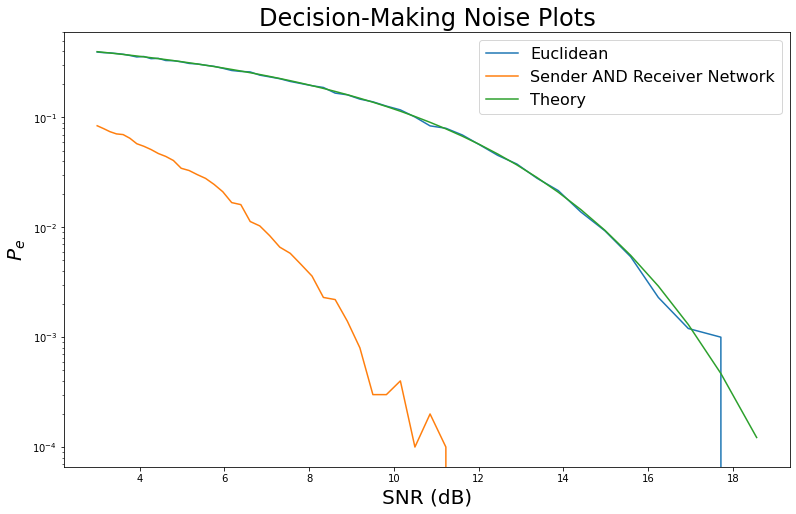

In [10]:
plt.figure(figsize=(13,8))
plt.title('Decision-Making Noise Plots', fontsize=24)
plt.xlabel('SNR (dB)', fontsize=20)
plt.ylabel('$P_e$', fontsize=20)
num = 0
plt.semilogy(SNRsDB[num:], error_rates_euclid[num:])
plt.semilogy(SNRsDB[num:], error_rates_joint[num:])
plt.semilogy(SNRsDB[num:], error_theory[num:])
legend = ['Euclidean', 'Sender AND Receiver Network', 'Theory']
plt.legend(legend, fontsize=16)
#plt.ylim([1e-3, 1])
plt.show()